# Metal Coordinating Network Oscillation

Fit oscillatory sweep of metal-coordinating polymer network.

**Data:** examples/data/oscillation/metal_networks/epstein.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import FractionalMaxwellModel, GeneralizedMaxwell, HerschelBulkley
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import os
import sys

import arviz as az

# Shared plotting utilities
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath("")), ".."))
from utils.plotting_utils import display_arviz_diagnostics


## Load frequency sweep

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'oscillation' / 'metal_networks'
df = pd.read_csv(DATA_DIR / 'epstein.csv', sep='	')
df.columns = df.columns.str.strip()
omega = df.iloc[:,0].to_numpy()
Gp = df.iloc[:,1].to_numpy()
Gpp = df.iloc[:,2].to_numpy()
G_star = Gp + 1j*Gpp


## Fit models

In [4]:
gm = GeneralizedMaxwell(n_modes=4, modulus_type='tensile')
gm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega)
gm_pred = gm_pred_components[:,0] + 1j*gm_pred_components[:,1]
gm_r2 = r2_complex(G_star, gm_pred)

fm_pred = np.full_like(G_star, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
    fm_pred = fm.predict(omega, test_mode='oscillation')
    fm_r2 = r2_complex(G_star, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed: {exc}")

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=4.000430s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=3698.3106 | elapsed=4.000s | final_gradient_norm=6.3845e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.065915s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=3698.3106 | elapsed=1.066s | final_gradient_norm=6.3845e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.097780s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=1.1515e+04 | elapsed=2.098s | final_gradient_norm=4.9188e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=4.549835s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=52 | final_cost=0.0512 | elapsed=4.550s | final_gradient_norm=1.4156e-06


{'gm_r2': 0.9996876727417076, 'fm_r2': 0.9972276067149991}


## Plot fits

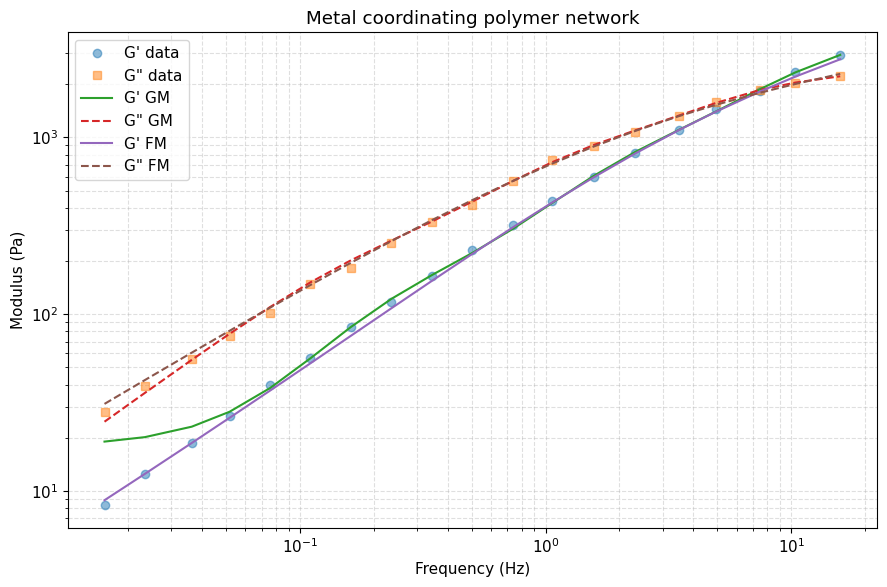

In [5]:
freq_hz = omega/(2*np.pi)
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(freq_hz, np.real(G_star), 'o', label="G' data", alpha=0.5)
ax.loglog(freq_hz, np.imag(G_star), 's', label='G" data', alpha=0.5)
ax.loglog(freq_hz, np.real(gm_pred), '-', label="G' GM")
ax.loglog(freq_hz, np.imag(gm_pred), '--', label='G" GM')
if np.isfinite(fm_r2):
    ax.loglog(freq_hz, np.real(fm_pred), '-', label="G' FM")
    ax.loglog(freq_hz, np.imag(fm_pred), '--', label='G" FM')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Modulus (Pa)')
ax.set_title('Metal coordinating polymer network')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

In [6]:
# Helper functions for workflow
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        """Compute R² for complex-valued data."""
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        """Convert 2-column real array to complex if needed."""
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr

NUTS_CONFIG = dict(num_chains=1, num_warmup=200, num_samples=500)  # Fast demo mode


In [7]:
def _detect_datasets():
    """Auto-detect datasets from global variables."""
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': G_star, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': Gp + 1j * Gpp, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        test_mode = master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation'
        datasets.append({
            'X': master.x, 'y': master.y, 'test_mode': test_mode,
            'x_label': 'Shifted frequency', 'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({'X': t, 'y': G, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'E_t' in globals():
        datasets.append({'X': t, 'y': E_t, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'sigma' in globals():
        datasets.append({'X': t, 'y': sigma, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Stress (Pa)'})
    if 't' in globals() and 'J' in globals():
        datasets.append({'X': t, 'y': J, 'test_mode': 'creep', 'x_label': 'Time (s)', 'y_label': 'Creep compliance'})
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals, 'y': y_vals, 'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})', 'y_label': 'Stress (Pa)', 'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined.')
    return datasets

def _collect_candidate_models():
    """Collect candidate models from global variables."""
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running.')
    return models

datasets = _detect_datasets()
model_entries = _collect_candidate_models()
print(f"Found {len(datasets)} dataset(s) and {len(model_entries)} model(s)")


Found 1 dataset(s) and 2 model(s)


In [8]:
# NLSQ fitting loop - fit all models to all datasets
all_fits = {}  # {dataset_idx: [fit_records]}

for ds_idx, ds in enumerate(datasets):
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            try:
                fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
            except Exception as exc:
                print(f"Skipping {name} due to fit error: {exc}")
                continue
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue

        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue

        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue

        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    all_fits[ds_idx] = fits
    if fits:
        print(f"Dataset {ds_idx} ranking: {[(r['name'], round(r['r2'], 3)) for r in fits]}")
    else:
        print(f"Dataset {ds_idx}: No successful fits")


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.878515s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=3698.3106 | elapsed=0.879s | final_gradient_norm=6.3845e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.101039s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=3698.3106 | elapsed=1.101s | final_gradient_norm=6.3845e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.859785s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=1.1515e+04 | elapsed=0.860s | final_gradient_norm=4.9188e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.429281s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=52 | final_cost=0.0512 | elapsed=1.429s | final_gradient_norm=1.4156e-06


Dataset 0 ranking: [('gm', 1.0), ('fm', 0.997)]


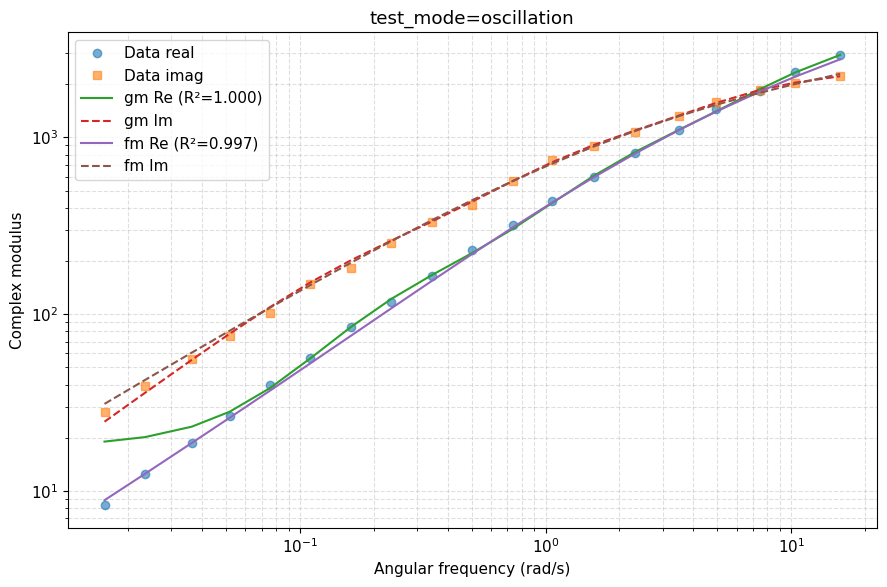

ERROR:rheojax.core.bayesian:bayesian_inference failed: Incompatible shapes for broadcasting: shapes=[(19, 2), (19,)]


ERROR:rheojax.core.base:Bayesian fit failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/jax/_src/lax/lax.py", line 215, in _broadcast_shapes_uncached
    return _try_broadcast_shapes(*rank_promoted_shapes, name='broadcast_shapes')
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/jax/_src/lax/lax.py", line 130, in _try_broadcast_shapes
    raise TypeError(f'{name} got incompatible shapes for broadcasting: '
                    f'{", ".join(map(str, map(tuple, shapes)))}.')
TypeError: broadcast_shapes got incompatible shapes for broadcasting: (19, 2), (1, 19).

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/jax/_src/lax/lax.py", line 193, in broadcast_shapes
    return _broadcast_shapes_cached(*shapes)
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-pac

Dataset 0: Bayesian step failed for gm: Incompatible shapes for broadcasting: shapes=[(19, 2), (19,)]


In [9]:
# Bayesian inference on best model per dataset
def _plot_data_and_fits(ds, fits):
    """Plot data with model fits overlay."""
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot, y_true = ds['X'], ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        ax.loglog(X_plot, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(X_plot, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

bayes_results = {}  # {dataset_idx: (bayes_result, param_names)}

for ds_idx, ds in enumerate(datasets):
    fits = all_fits.get(ds_idx, [])
    if not fits:
        continue

    best = fits[0]
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'], ds['y'], **NUTS_CONFIG, test_mode=ds['test_mode'],
        )
        param_names = list(best['model'].parameters.keys())
        bayes_results[ds_idx] = (bayes_result, param_names)
        print(f"Dataset {ds_idx}: Bayesian inference complete for {best['name']}")
    except Exception as exc:
        print(f"Dataset {ds_idx}: Bayesian step failed for {best['name']}: {exc}")


In [10]:
# ArviZ diagnostics for Bayesian results
for ds_idx, (bayes_result, param_names) in bayes_results.items():
    print(f"\n--- Diagnostics for dataset {ds_idx} ---")
    display_arviz_diagnostics(bayes_result, param_names, fast_mode=True)
